<a href="https://colab.research.google.com/github/choudhurysibani120/credit-card-default-prediction/blob/main/Copy_of_Credit_Card_Default_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Predicting whether a customer will default on his/her credit card </u></b>

## <b> Problem Description </b>

### This project is aimed at predicting the case of customers default payments in Taiwan. From the perspective of risk management, the result of predictive accuracy of the estimated probability of default will be more valuable than the binary result of classification - credible or not credible clients. We can use the [K-S chart](https://www.listendata.com/2019/07/KS-Statistics-Python.html) to evaluate which customers will default on their credit card payments


## <b> Data Description </b>

### <b>Attribute Information: </b>

### This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:
* ### X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
* ### X2: Gender (1 = male; 2 = female).
* ### X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
* ### X4: Marital status (1 = married; 2 = single; 3 = others).
* ### X5: Age (year).
* ### X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
* ### X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
* ### X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import warnings
warnings.simplefilter("ignore")
from pprint import pprint
import joblib
import imblearn

from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

from sklearn import metrics  
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_excel('/content/drive/MyDrive/Copy of default of credit card clients.xls',header=1)

In [4]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

In [6]:
data.loc[0]

ID                                1
LIMIT_BAL                     20000
SEX                               2
EDUCATION                         2
MARRIAGE                          1
AGE                              24
PAY_0                             2
PAY_2                             2
PAY_3                            -1
PAY_4                            -1
PAY_5                            -2
PAY_6                            -2
BILL_AMT1                      3913
BILL_AMT2                      3102
BILL_AMT3                       689
BILL_AMT4                         0
BILL_AMT5                         0
BILL_AMT6                         0
PAY_AMT1                          0
PAY_AMT2                        689
PAY_AMT3                          0
PAY_AMT4                          0
PAY_AMT5                          0
PAY_AMT6                          0
default payment next month        1
Name: 0, dtype: int64

From dataset documentation: PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above). Notice code 0 and 2 are in the PAY_X columns but are not included in the data description. Also by doing the value_counts, it shows 0 is the most frequent observation.

-2: No consumption;

-1: Paid in full;

0: The use of revolving credit, meaning the payment wasn't due, which makes sense that most customers were using the revolving credit.

(3) What does 'default.payment.next.month' mean?¶

Is it a predictor or actual data that was collected in the next month - Oct. 2005? According to the reply from the dataset contributor,it seems this is the actual data collected in the next month. "Y: client's behavior; Y=0 then not default, Y=1 then default". This information could be used to test the accuracy of the model that will be built.

In [7]:

# Get the proportion of customers who had default payment in the next month (Oct.2005)? 
# About 22% customers had default payment next month

data['default payment next month'].value_counts(normalize=True)

0    0.7788
1    0.2212
Name: default payment next month, dtype: float64

In [8]:
# Sort the repayment status codes in PAY_X columns by melting them into 1 column
# Notice there are 2 undocumented codes: 0,-2

pay = data[['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']]
pay_melt = pd.melt(pay)
print(pay_melt['value'].value_counts())

 0    95919
-1    34640
-2    24415
 2    18964
 1     3722
 3     1430
 4      453
 7      218
 5      137
 6       74
 8       28
Name: value, dtype: int64


In [9]:
# Check column names, columan data type and indentify any missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

In [10]:
# Change inconsistent column names "PAY_0" to 'PAY_1', 'default.payment.next.month'to 'DEF_PAY_NMO'

data.rename(columns={'PAY_0':'PAY_1','default payment next month':'DEF_PAY_NMO'},inplace = True)
data.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'DEF_PAY_NMO'],
      dtype='object')

(2) Check duplicate records¶

There are no duplicate IDs or rows.

In [11]:
# Check if there is any duplicate IDs
condition = bool(data.duplicated(subset = 'ID').any())

if condition:
    print('There are duplicate IDs')
else:
    print('No duplicate IDs')

No duplicate IDs


(3) Identify outliers

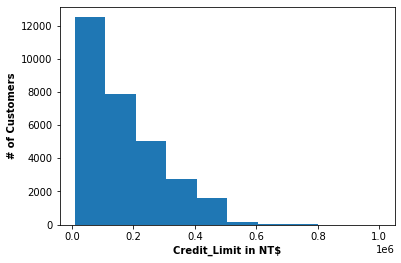

In [12]:
# Use histogram to view the distribution of credit limit

plt.hist(data["LIMIT_BAL"])
plt.xlabel('Credit_Limit in NT$', fontweight='bold')
plt.ylabel('# of Customers', fontweight='bold')
plt.show()

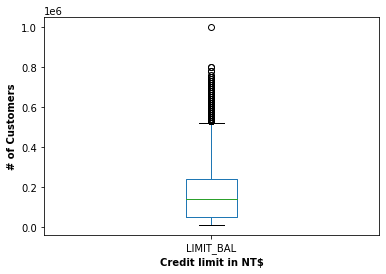

In [13]:
# Use boxplot to identify any outlier in credit limit

data["LIMIT_BAL"].plot(kind="box")
plt.xlabel('Credit limit in NT$', fontweight='bold')
plt.ylabel('# of Customers', fontweight='bold')
plt.show()

In [14]:
# Take a close look at the outlier
# The observations from other columns indicate that this was just a customer who has an excellent payment history
# Therefore it should be considered as a valid data

outliers = data.loc[data['LIMIT_BAL']>900000]
outliers

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEF_PAY_NMO
2197,2198,1000000,2,1,1,47,0,0,0,-1,0,0,964511,983931,535020,891586,927171,961664,50784,50723,896040,50000,50000,50256,0


(4) Check numerical column

In [15]:
# Get the statistic summary of the columns
# No data is extremly unresonable in these columns

data.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEF_PAY_NMO
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [16]:
data.to_csv("copy of default of credit card clients.csv", index=None)

(5) Check categorical columns¶

Next, we will check these 3 columns: SEX', 'EDUCATION' and 'MARRIAGE'. The 'SEX' column looks fine, while 'EDUCATION' and 'MARRIAGE' columns have some undocumented data and 'EDUCATION' column has duplicated values in different codes.

In [17]:

# Get SEX column's distribution. 1: male; 2: female
# No undocumented SEX code

data["SEX"].value_counts()

2    18112
1    11888
Name: SEX, dtype: int64

In [18]:
# Change sex code to 'F' and 'M' and use category as datatype

data["SEX"]=data["SEX"].map({1:'M',2:'F'}).astype('category')
data["SEX"].dtypes

CategoricalDtype(categories=['F', 'M'], ordered=False)


'EDUCATION' column: notice 5 and 6 are both recorded as 'unknown' and there is 0 which isn't explained in the dataset description. Since the amounts are so small, let's combine 0,4,5,6 to 0 which means"other"

In [19]:
# EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)

data["EDUCATION"].unique()

array([2, 1, 3, 5, 4, 6, 0])

In [20]:
# Get the total counts of each EDUCATION level

data["EDUCATION"].value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

In [21]:
# Change values 4, 5, 6 to 0 and define 0 as 'others'
# 1=graduate school, 2=university, 3=high school, 0=others

data["EDUCATION"] = data["EDUCATION"].replace({4:0,5:0,6:0})
data["EDUCATION"].value_counts()

2    14030
1    10585
3     4917
0      468
Name: EDUCATION, dtype: int64

'MARRIAGE' column: what does 0 mean in 'MARRIAGE'? Since there are only 0.18% (or 54) observations of 0, we will combine 0 and 3 in one value as 'others'

In [22]:

# From dataset description: MARRIAGE: Marital status (1=married, 2=single, 3=others), but there is also 0

data["MARRIAGE"].unique()

array([1, 2, 3, 0])

In [23]:
# How many customers had "MARRIAGE" status as 0?

data["MARRIAGE"].value_counts(normalize=True)

2    0.532133
1    0.455300
3    0.010767
0    0.001800
Name: MARRIAGE, dtype: float64

In [24]:
# Combine 0 and 3 by changing the value 0 into 3

data["MARRIAGE"] = data["MARRIAGE"].replace({0:3})
data["MARRIAGE"].value_counts(normalize=True)

2    0.532133
1    0.455300
3    0.012567
Name: MARRIAGE, dtype: float64


4. Trends, Hypotheses and Findings

In [25]:
# Set ID as dataframe index

data.set_index('ID', inplace = True)
data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEF_PAY_NMO
ID,,,,,,,,,,,,,,,,,,,,,,,,
1,20000,F,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,120000,F,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,F,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,F,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,M,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [26]:
# Create a new column "HAS_DEF" to indicate customers who have at least 1 deafult payment from PAY_1 to Pay_6
# 0 : no default ; 1: has default

def_condition = (data.PAY_1 >1) | (data.PAY_2 >1) | (data.PAY_3 >1) | (data.PAY_4 >1) | (data.PAY_5 >1) | (data.PAY_6 >1)
data.loc[def_condition, "HAS_DEF"] = 1
data.loc[data.HAS_DEF.isna(), "HAS_DEF"] = 0


(1) On average, which sex group tends to have more delayed payments? Since there are more female than male in the dataset, we will use percentage within each sex group.¶

30% male have default payment while 26% female have default payment, the difference is not significant.

In [27]:

def create_stacked_bar(column_name):

    # Get the percentage of default by each group
    default_by_group = pd.crosstab(index=data['HAS_DEF'],columns = data[column_name], normalize = 'columns')
    
    # Round up to 2 decimal
    default_by_group = default_by_group.apply(lambda x: round(x,2))
    
    labels = default_by_group.columns
    list1 = default_by_group.iloc[0].to_list()
    list2 = default_by_group.iloc[1].to_list()
    
    list1_name = "No default"
    list2_name = "Has default"
    title = f"Default by {column_name}"
    xlabel = column_name
    ylabel = "Default percentage"
    
    fig, ax = plt.subplots(figsize=(10, 5))
    bar_width = 0.5
    
    ax1 = ax.bar(labels,list1, bar_width, label = list1_name)
    ax2 = ax.bar(labels,list2, bar_width, bottom = list1, label = list2_name)

    ax.set_title(title, fontweight = "bold")
    ax.set_xlabel(xlabel, fontweight = "bold")
    ax.set_ylabel(ylabel, fontweight = "bold")
    ax.legend(loc="best")
    
    plt.xticks(list(range(len(labels))), labels,rotation=90)
    plt.yticks(fontsize=9)

    for r1, r2 in zip(ax1, ax2):
        h1 = r1.get_height()
        h2 = r2.get_height()
        plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., f"{h1:.0%}", ha="center", va="center", color="white", fontsize=9, fontweight="bold")
        plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., f"{h2:.0%}", ha="center", va="center", color="white", fontsize=9, fontweight="bold")

    plt.show()

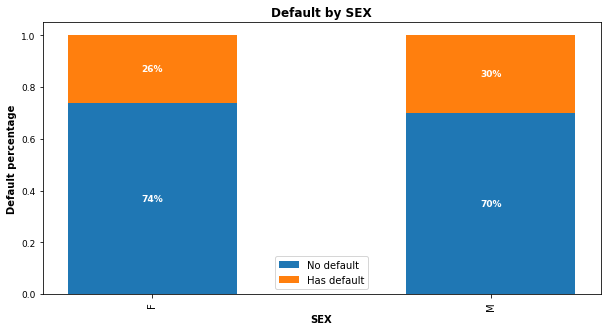

In [28]:
# Plot a stacked bar chart to visualize default percentage by female and male

create_stacked_bar('SEX')

(2) Did customers with higher education have less delayed payment?

The data indicates customers with lower education levels default more. Customers with high school and university educational level had higher default percentages than customers with grad school education did.

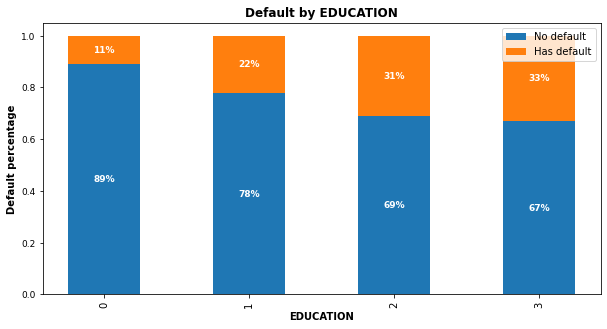

In [29]:
# Plot a stacked bar chart to show default by education level

create_stacked_bar('EDUCATION')

(3) Did customers with a high education level get higher credit limits?

From the boxplot, we can see that customers with grad school education have the highest 25% percentile,highest median,highest 75th percentile and highest maximum numbers, which proves that customers with higher education levels did get higher credit limits.

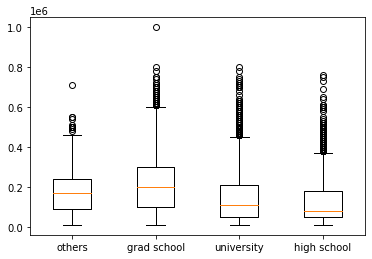

In [30]:
# Use boxplot to visualize credit limit grouped by education level

data1 = []
for i in [0,1,2,3]:
    temp = data.loc[data.EDUCATION == i, "LIMIT_BAL"]
    data1.append(temp)

fig, ax = plt.subplots()
ax.boxplot(data1)
ax.set_xticklabels(["others","grad school", "university", "high school"])

plt.show()

(4) Does marital status have anything to do with default risk?
 Note the credit limit includes the family's total credit.¶
 
There is no difference of default risk in terms of marital status, although the 'other'marital status group had high default percentage.

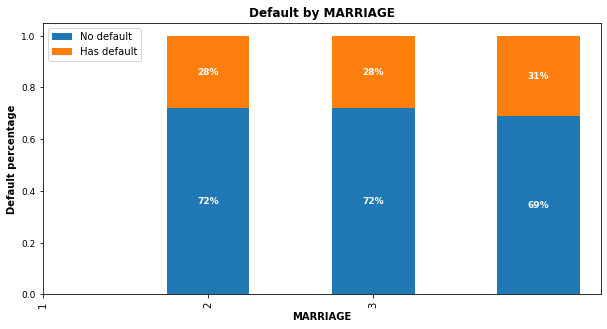

In [31]:
# Plot a stacked bar chart to visualize default and non-default distribution by marital status 

create_stacked_bar('MARRIAGE')


(5) Do younger people tend to miss the payment deadline?

Customers aged between 30-50 had the lowest delayed payment rate, while younger groups (20-30) and older groups (50-70) all had higher delayed payment rates. However, the delayed rate dropped slightly again in customers older than 70 years.

In [32]:

# Segment the 'AGE' column to 6 groups

bins= [21,30,40,50,60,70,80]
labels = ['20-30','30-40','40-50','50-60','60-70','70-80']
data['AGE'] = pd.cut(data['AGE'],bins=bins, labels=labels,right=False)


(6) Has the repayment status changed in the 6 month from April 2005 (PAY_6) to September 2005(PAY_0)?

There was a huge jump from May,2005 (PAY_5) to July, 2005 (PAY_3) when delayed payment increased significantly, then it peaked at August, 2005 (PAY_2), things started to get better in September, 2005 (PAY_1)

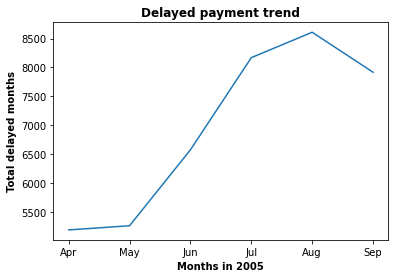

In [33]:
# Subset a dataframe with the records that have default

has_default = data[data['HAS_DEF']== 1]
default_trend = has_default[['PAY_6','PAY_5','PAY_4','PAY_3','PAY_2','PAY_1']].sum(axis=0)

# Draw a line chart to show the trend. The lower the number, the shorter delayed payment
fig,ax = plt.subplots()
ax.plot(default_trend)
plt.xticks(['PAY_6','PAY_5','PAY_4','PAY_3','PAY_2','PAY_1'],['Apr','May','Jun','Jul','Aug','Sep'])

plt.xlabel('Months in 2005',fontweight='bold')
plt.ylabel('Total delayed months',fontweight='bold')
plt.title('Delayed payment trend',fontweight='bold')

plt.show()


(7) Is there any correlation between bill amount and the delayed time?¶

There isn't an obvious correlation between bill amount and the total months of delay

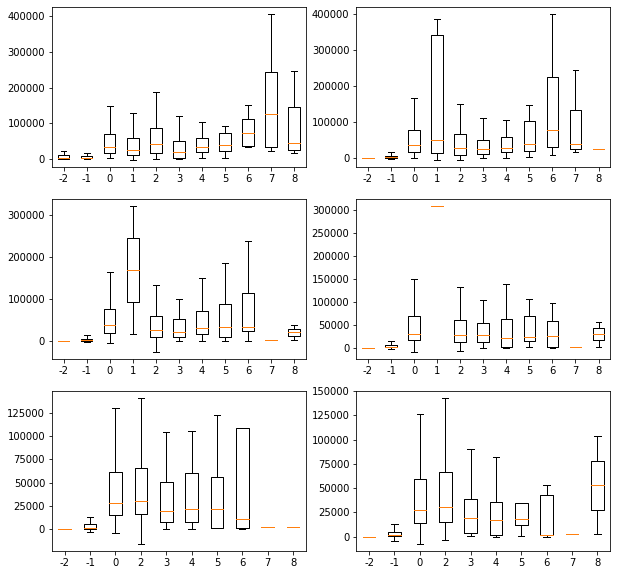

In [34]:

# Make 6 boxplots to visualize bill amounts and the total months of delayed payment

from matplotlib.pyplot import figure

# Make "PAY_1" to"PAY_6" , 'BILL_AMT1" to'BILL_AMT6" into a list respectively
pay_list = [ f"PAY_{i}" for i in range(1, 7) ]
bill_amt_list = [ f"BILL_AMT{i}" for i in range(1, 7) ]

fig, ax = plt.subplots(3,2, figsize=(10, 10))

for pay, bill_amt, myax in zip(pay_list, bill_amt_list, ax.flatten()):
    
    # Prepare data for boxploting
    data1 = []
    for i in sorted(has_default[pay].unique()):
        temp = has_default.loc[has_default[pay] == i, bill_amt]
        data1.append(temp)
        
    # Make boxplot for each PAY variable
    myax.boxplot(data1, showfliers=False,) 
    myax.set_xticklabels(sorted(has_default[pay].unique()))
    
plt.show()


(8) Is there any correlation between credit limit and the default payment next month?

Unsurprisingly, customers who had higher credit limits had lower delayed payment rates.

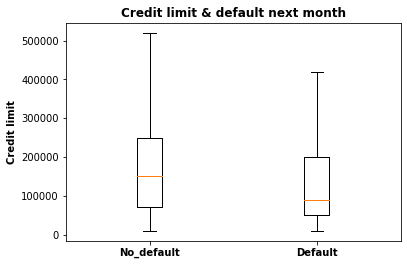

In [35]:
# Make a boxplot to visualize credit limit and default payment next month
# 1: default next month; 0: no default next month

def0 = data.loc[data['DEF_PAY_NMO'] == 0,'LIMIT_BAL']
def1 = data.loc[data['DEF_PAY_NMO'] == 1,'LIMIT_BAL']

fig, ax = plt.subplots()
ax.boxplot([def0, def1],  showfliers=False)

ax.set_xticklabels(['No_default',"Default"],fontweight ='bold')
ax.set_ylabel('Credit limit',fontweight ='bold')
ax.set_title('Credit limit & default next month',fontweight ='bold')

plt.show()

Customers with high credit limits tend to have higher 'no-default'rate.

(9) Why are there negative bills?

Interestingly enough, the minimals of those 6 bill columns are negative numbers. In general, there are 599-688 bills with negative amounts each month, which is less than 2% of total 30,000 records monthly. Also, the average negative amount in USD is $38 - $102 which is a small amount. Therefore, an informed guess would be these are refunds from the last billing cycle. This will be investigated in data analysis

In [36]:

# Get statistic summary of bill statement columns
# The min numbers are negative

bill = data[['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']]
bill.describe()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
count,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000
mean,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400
std,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537
min,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000
25%,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000
50%,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000
75%,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000
max,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000


In [37]:
# How many bills have negative amount?
# There are 3932 bills with negative amounts, each month has 599-688 records 

bill_melt = pd.melt(bill, var_name = 'bill_cycle',value_name = 'amount')
neg_bill = bill_melt[bill_melt['amount']<0]
neg_bill.groupby('bill_cycle').count()

,amount
bill_cycle,
BILL_AMT1,590
BILL_AMT2,669
BILL_AMT3,655
BILL_AMT4,675
BILL_AMT5,655
BILL_AMT6,688


In [38]:
# Get the average amount of negative bill each month
# Use USD/NTD = 30 to get the amount in USD. The average negative amount is $38-$102

neg_bill_mean_ndt = neg_bill.groupby('bill_cycle')['amount'].mean()

print('Average negative amounts in NTD are: \n')
print(neg_bill_mean_ndt)
print('\nAverage negative amounts in USD are: \n')
print(neg_bill_mean_ndt/30)

Average negative amounts in NTD are: 

bill_cycle
BILL_AMT1   -1154.796610
BILL_AMT2   -1230.621824
BILL_AMT3   -1466.291603
BILL_AMT4   -1631.242963
BILL_AMT5   -1634.708397
BILL_AMT6   -3074.492733
Name: amount, dtype: float64

Average negative amounts in USD are: 

bill_cycle
BILL_AMT1    -38.493220
BILL_AMT2    -41.020727
BILL_AMT3    -48.876387
BILL_AMT4    -54.374765
BILL_AMT5    -54.490280
BILL_AMT6   -102.483091
Name: amount, dtype: float64



(10) Why are some bill statement amounts greater than credit limit? Could it be late payment interest?

The common sense is that the bill statement amount shouldn't exceed credit limit, however, there are 3931 customers whose bill amounts are greater than credit limit. Could the difference be late payment interest assuming these customers had delayed payment?

In [39]:
# Is there any bill amount that is greater than credit limit?

condition1 = data['BILL_AMT1'] > data['LIMIT_BAL'] 
condition2 = data['BILL_AMT2'] > data['LIMIT_BAL'] 
condition3 = data['BILL_AMT3'] > data['LIMIT_BAL'] 
condition4 = data['BILL_AMT4'] > data['LIMIT_BAL'] 
condition5 = data['BILL_AMT5'] > data['LIMIT_BAL'] 
condition6 = data['BILL_AMT6'] > data['LIMIT_BAL'] 

large_bill = data[condition1 | condition2 |condition3 | condition4 | condition5 | condition6]
large_bill.shape

(3931, 25)

In [40]:

large_bill["HAS_DEF"].value_counts()

0.0    2184
1.0    1747
Name: HAS_DEF, dtype: int64

(11) Why did customers who had no consumption in 6 months then default in the next month?

First explore if there is any customer who never had consumption and the data shows there are 870 customers who were inactive in 6 months. Then check against the 'default.payment.next.month' column to see if these customers all had no default. The common sense should be no default payment next month if the previous bill was 0. However, we see there are 317 "1"s which means default in the next month. We will investigate this in the data analysis process.

In [41]:
# Is there any customer who never had any transaction, meaning bill amount in 6 months remained as 0
# There are 870 customers whose bill amount was 0 in 6 months

bill_amt = data[['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']]
no_transaction = bill_amt[bill_amt.sum(axis=1) ==0]
no_transaction

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
ID,,,,,,
19,0,0,0,0,0,0
20,0,0,0,0,0,0
46,0,0,0,0,0,0
80,0,0,0,0,0,0
122,0,0,0,0,0,0
...,...,...,...,...,...,...
29909,0,0,0,0,0,0
29910,0,0,0,0,0,0
29974,0,0,0,0,0,0


In [42]:
# Check if those 870 customers defaulted in the next month (Oct.2005)
# The assumption is since they did not have any consumption, they shouldn't default, so there shouldn't be any '1'

no_transaction_de = data.loc[no_transaction.index,['DEF_PAY_NMO']]
no_transaction_de

,DEF_PAY_NMO
ID,
19,0
20,0
46,1
80,1
122,1
...,...
29909,1
29910,0
29974,1


In [43]:
# How many inactive customers had default payment next month
# 317 customers had default payment next month which is against common sense

no_transaction_de['DEF_PAY_NMO'].value_counts()

0    553
1    317
Name: DEF_PAY_NMO, dtype: int64


5. Statistical Analysis

Should this section be embeded to previous EDA step?

Correlation between credit limit and bill amount: Pearson R

Correlation between credit limit and payment default: t-test

Correlation between education and payment default: chi-squared test

Correlation between age and payment default: chi-squared test

Correlation between sex and payment default: permutation test

Correlation between sex and credit limit: t-test


Correlation between credit limit and bill amount.

We assume customers who have a high credit limit will have a higher bill amount.

In [44]:
data['BILL_SUM'] = data[['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']].sum(axis=1)
credit_bill = data[['LIMIT_BAL','BILL_SUM']]
credit_bill.corr()

,LIMIT_BAL,BILL_SUM
LIMIT_BAL,1.000000,0.302044
BILL_SUM,0.302044,1.000000


In [45]:
from scipy import stats

credit_limit = data['LIMIT_BAL']
bill_amount = data[['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']].sum(axis=1)

stats.pearsonr(credit_limit, bill_amount)

(0.30204379702615786, 0.0)


The Pearson R shows there is a positive correlation between these 2 variables.

Correlation between credit limit and payment default.

Ideally, we should have customers' income data, but since this data is not available, we can assume higher income customers have higher credit limits. Therefore, we will verify if there is a correlation between credit limit and default payment using t-test.

Null hypothesis: credit limit does not affect default likelihood.

Alternative hypothesis: credit limit impact default likelihood.

Set significance level $\alpha$ to 0.05

In [46]:
no_def_limit = data.loc[data['HAS_DEF']==0,'LIMIT_BAL']
def_limit = data.loc[data['HAS_DEF']==1,'LIMIT_BAL']

In [47]:
from scipy import stats
from scipy.stats import ttest_ind_from_stats

ttest_ind_from_stats(mean1=np.mean(no_def_limit),std1=np.std(no_def_limit),nobs1=len(no_def_limit),
                     mean2=np.mean(def_limit),std2=np.std(def_limit),nobs2=len(def_limit))

Ttest_indResult(statistic=46.758765680556394, pvalue=0.0)

We get a p value as 0, therefore we need to reject the null hypothesis and accept the alternative hypothesis. Credit limit has an impact on payment default.

Correlation between education and payment default.
Previous visualization indicates education impacts default likelihood. We will use a Chi-squared test to verify this finding.

Null hypothesis: education does not affect default likelihood.

Alternative hypothesis: education impacts default likelihood.

Set significance level $\alpha$ to 0.05

In [48]:

# Get the contigence table of education and default data

edu_def_contigence = pd.crosstab(data['HAS_DEF'], data['EDUCATION'], margins=False)

In [49]:

# Use Chi-squared test to test if education affects default likelihood.

from scipy.stats import chisquare
from scipy.stats import chi2_contingency
stat, p, dof, expected = chi2_contingency(edu_def_contigence)

p

9.997508691343157e-76


Since the p value is close to 0, we will reject the null hypothesis and accept the alternative hypothesis. Because education has a strong correlation with default probability, we should keep this variable in the machine learning model.

Correlation between age and payment default.

Previous visualization indicates age impacts default likelihood. We will use a chi-squared test to verify this finding.

Null hypothesis: age does not affect default likelihood.

Alternative hypothesis: age impacts default likelihood.

Set significance level $\alpha$ to 0.05

In [50]:

# Get the contigence table of age and default data

age_def_contigence = pd.crosstab(data['HAS_DEF'], data['AGE'], margins=False)

In [51]:
# Use chi-squared test to test if age affects default likelihood.

from scipy.stats import chisquare
from scipy.stats import chi2_contingency
stat, p, dof, expected = chi2_contingency(age_def_contigence)

p

6.185243361338736e-26

The p value is smaller than significance level $\alpha$, we will reject the null hypothesis and accept the alternative hypothesis, which is age has impact on default probability.


Correlation between sex and payment default.

In previous data visualization, it appears males tend to default more than females. Does sex have any correlations with default or was this observation due to chance event? Let's find out with a permutation test on each group's default proportions and mean respectively.

Null hypothesis: sex has no impact on default probability.
Alternative hypothesis: sex has impact on default probability.
Set significance level $\alpha$ to 0.05.

In [52]:
# Get the true difference of 'HAS_DEF' proportions of two sex groups

male = data.loc[data['SEX']=='M','HAS_DEF']
female = data.loc[data['SEX']=='F','HAS_DEF']
true_diff_prop = male.sum()/len(male) - female.sum()/len(female)
true_diff_prop

0.03849496062187008

In [53]:
 #Define functions to do permutation test

def permutation_sample(data2, data3):
    data1 = np.concatenate((data2,data3))
    permuted_data1 = np.random.permutation(data1)
    perm_sample_1 = permuted_data1[:len(data2)]
    perm_sample_2 = permuted_data1[len(data3):]

    return perm_sample_1, perm_sample_2

def diff_of_prop(data2,data3):
    diff = data2.sum()/len(data2) - data3.sum()/len(data3)

    return diff

def draw_perm_reps(data2, data3, func, size=1):
    perm_replicates = np.empty(size)

    for i in range(size):
        perm_sample_1, perm_sample_2 = permutation_sample(data2,data3)
        perm_replicates[i] = func(perm_sample_1,perm_sample_2)

    return perm_replicates

In [54]:
# Draw 10000 permutation tests

perm_replicates = draw_perm_reps(male,female,diff_of_prop,size=10000)

In [55]:
# Calculate p value - the probability of getting a mean difference equal or greater than the observed mean difference

p = np.sum(perm_replicates >= true_diff_prop) / len(perm_replicates)
p

0.0


Test conclusion: since the p value is 0, we should reject the null hypothsis and accept the alternative hypothsis, which is sex has impact on default likelihood. To be more concrete in this case, male customers tend to default more.

Correlation between credit limit and sex.

Since we know the credit limit is strongly correlated with default probability. Let's see if sex plays any role in credit limit and default likelihood.

Null hypothesis: sex has no impact on credit limit.

Alternative hypothesis: sex has impact on credit limit.

Set significance level $\alpha$ to 0.05

In [56]:
# Calculate the true mean difference of credit limit

male_limit= data.loc[data['SEX']=='M','LIMIT_BAL']
female_limit = data.loc[data['SEX']=='F','LIMIT_BAL']
print(np.mean(male_limit),np.mean(female_limit))

163519.8250336474 170086.46201413427


In [57]:
# Use t-test to verify if different sex groups have the same mean of credit limit.

from scipy import stats
from scipy.stats import ttest_ind_from_stats

ttest_ind_from_stats(mean1=np.mean(male_limit),std1=np.std(male_limit),nobs1=len(male_limit),
                     mean2=np.mean(female_limit),std2=np.std(female_limit),nobs2=len(female_limit))

Ttest_indResult(statistic=-4.289049447941391, pvalue=1.8000013013822418e-05)

The p value is much lower than 𝛼 , so we will reject null hypothesis and accept alternative hypothesis. We have verified that sex plays a role in credit limit and it is not due to chance.

Prepare for Modeling

1. Feature Engineering

In [58]:
data = pd.read_csv('/content/copy of default of credit card clients.csv')

In [59]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEF_PAY_NMO
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [60]:
# Bin ‘AGE’ data to 6 groups
bins= [21,30,40,50,60,70,80]
labels = list(range(6))
data['AGE'] = pd.cut(data['AGE'],bins=bins, labels=labels,right=False)

# Covert categorical column into integer by extracting the code of the categories
data.AGE = data.AGE.cat.codes


2. Feature Selection

In [61]:
# Define predictor variables and target variable
X = data.drop(columns=['ID','DEF_PAY_NMO'])
y = data['DEF_PAY_NMO']

# Save all feature names as list
feature_cols = X.columns.tolist() 

# Extract numerical columns and save as a list for rescaling
X_num = X.drop(columns=['SEX', 'EDUCATION', 'MARRIAGE', 'AGE'])
num_cols = X_num.columns.tolist()

In [62]:
num_cols

['LIMIT_BAL',
 'PAY_1',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6']

3. Check Class Imbalance

0    0.7788
1    0.2212
Name: DEF_PAY_NMO, dtype: float64


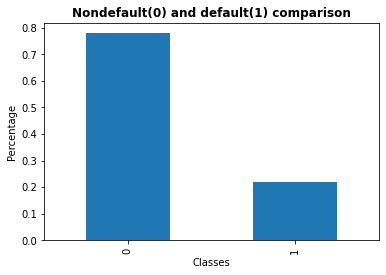

In [63]:
# Check target classes balancec
cla_bal = data['DEF_PAY_NMO'].value_counts(normalize=True)
print(cla_bal)

# Plot the classes
cla_bal.plot(kind = 'bar')
plt.title('Nondefault(0) and default(1) comparison',fontweight = "bold")
plt.xlabel('Classes')
plt.ylabel('Percentage')
plt.show()

With typical default classification problems, we expect imbalanced classes as we know most people will not default. This dataset is also imbalanced, with 78% non-default vs. 22% default


4. Split Training and Test Data

In [64]:
# Define function to split data with and without SMOTE 

def data_split(X, y, imbalance = False):
    # split data 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,shuffle=True, stratify=y, random_state=42)
    
    if imbalance:
        # use SMOTE to over sample data
        from imblearn.over_sampling import SMOTE
        sm = SMOTE(random_state = 42)
        X_train, y_train = sm.fit_sample(X_train, y_train.ravel())
    
    return X_train, X_test, y_train, y_test

5. Rescale Features

In [65]:
# Define function to rescale training data using StandardScaler

def standard_scaler(X_train, X_test, numerical_cols):
    
    # Make copies of dataset
    X_train_std = X_train.copy()
    X_test_std = X_test.copy()
    
    # Apply standardization on numerical features only
    for i in numerical_cols:
      scl = StandardScaler().fit(X_train_std[[i]])     # fit on training data columns
      X_train_std[i] = scl.transform(X_train_std[[i]]) # transform the training data columns
      X_test_std[i] = scl.transform(X_test_std[[i]])   # transform the testing data columns
    
    return X_train_std,X_test_std


Classification Predictive Modeling

1. Logistic Regression

Rescaling the features variables then run Logistic Regression with and without SMOTE sampling to compare ROC_AUC scores.


Since SMOTE sampling yields a much better ROC_AUC score on training data, we will use SMOTE while tuning the model.


Tune Parameters of Logistic Regression

In [98]:
def run_logistic_regression(imbalance=False):
    # Split data  
    X_train, X_test, y_train, y_test = data_split(X, y, imbalance = imbalance)

    # Rescale data
    X_train_std, X_test_std = standard_scaler(X_train, X_test, numerical_cols = num_cols)
    
    # Instantiate model
    clf_lr = LogisticRegression(random_state=42)
    
    # Fit the model
    clf_lr.fit(X_train, y_train)

    # Use model's default parameters to get cross validation score
    scores = cross_val_score(clf_lr, X_train, y_train, scoring ="roc_auc", cv = 5)
    roc_auc_lr = np.mean(scores)
    
    if imbalance:
        return "Logistic Regression", "With SMOTE", roc_auc_lr
    else:
        return "Logistic Regression", "Without SMOTE", roc_auc_lr

model_result = []
model_result.append(run_logistic_regression())
model_result.append(run_logistic_regression(imbalance=True))

pd.DataFrame(model_result, columns = ["Model", "SMOTE", "ROC_AUC Score"])

IndexError: ignored

In [67]:
# Randomized search for the best C parameter

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Split data with SMOTE 
X_train, X_test, y_train, y_test = data_split(X, y, imbalance = True) 

# Rescale data
#X_train_std, X_test_std = standard_scaler(X_train, X_test, numerical_cols = num_cols)

logistic = LogisticRegression(solver='saga', tol=1e-2, max_iter=200,random_state=42)
distributions = dict(C=uniform(loc=0, scale=4), penalty=['l2', 'l1'])
clf = RandomizedSearchCV(logistic, distributions, random_state=42)

lr_best= clf.fit(X_train, y_train)   

print(lr_best.best_params_)

{'C': 1.49816047538945, 'penalty': 'l2'}


In [68]:
joblib.dump(lr_best,"logreg_sm_tuned.pkl")

['logreg_sm_tuned.pkl']

In [69]:
lr_best = joblib.load("logreg_sm_tuned.pkl")

In [70]:
scores_tuned = cross_val_score(lr_best, X_train, y_train, scoring = "roc_auc", cv = 5)
roc_auc_lr_best = np.mean(scores_tuned)

print(f'ROC_AUC score after tuning parameters:{roc_auc_lr_best:.3f}')

ROC_AUC score after tuning parameters:0.653


In [71]:
joblib.dump(roc_auc_lr_best,"logreg_ROC_AUC_CV.pkl")

['logreg_ROC_AUC_CV.pkl']

In [72]:

roc_auc_lr_best = joblib.load("logreg_ROC_AUC_CV.pkl")
roc_auc_lr_best

0.6527751496550147

In [73]:
# Define a function to compute Precision, Recall and F1 score

def get_pre_rec_f1(model,X_test,y_test):
    y_pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    F1 = 2 * (precision * recall) / (precision + recall)
    
    print(f'Precision:{precision:.3f}\nRecall:{recall:.3f}\nF1 score:{F1:.3f}')

In [74]:
# Calculate precision and recall of Logistic Regression model

print('Logistic Regression model on test data:')
get_pre_rec_f1(lr_best, X_test, y_test)

Logistic Regression model on test data:
Precision:0.322
Recall:0.342
F1 score:0.332


Random forest

In [75]:
def run_random_forest(imbalance=False):
    # Split data  
    X_train, X_test, y_train, y_test = data_split(X, y, imbalance = imbalance)
    
    # Instantiate model
    clf_rf = RandomForestClassifier()
   
    # Fit the model
    clf_rf.fit(X_train, y_train)

    # Use model's default parameters to get cross validation score
    scores = cross_val_score(clf_rf, X_train, y_train, scoring ="roc_auc", cv = 5)
    roc_auc_rf = np.mean(scores)
    
    if imbalance:
        return "Random Forest", "With SMOTE", roc_auc_rf
    else:
        return "Random Forest", "Without SMOTE", roc_auc_rf

model_result = []
model_result.append(run_random_forest())
model_result.append(run_random_forest(imbalance=True))

pd.DataFrame(model_result, columns = ["Model", "SMOTE", "ROC_AUC Score"])

,Model,SMOTE,ROC_AUC Score
0,Random Forest,Without SMOTE,0.762331
1,Random Forest,With SMOTE,0.916206


Again, SMOTE sampling has a better performance. With the default parameters, Random Forest model generated ROC-AUC score 0.916 on training data, which is better than Logistic Regression model. Next, we will try to fine tune the hyperparameters with SMOTE sampling.

Tune Parameters of Random Forest

In [76]:
# Split data with SMOTE
X_train_sm, X_test, y_train_sm, y_test = data_split(X, y, imbalance = True)

In [77]:
# Create parameter grid  
param_grid = {
    'max_depth': [60, 90, 110],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300]
}

# Instantiate the model
clf_rf = RandomForestClassifier()

# Instantiate grid search model
grid_search = GridSearchCV(estimator = clf_rf, param_grid = param_grid,    
                          cv = 3, n_jobs = -1, verbose = 1)

# Fit grid search to the data
grid_search.fit(X_train_sm, y_train_sm)
grid_search.best_params_

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 26.4min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed: 32.8min finished


{'max_depth': 90,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 200}

In [78]:
joblib.dump(grid_search,"RandomForest_tuned_final.pkl")

['RandomForest_tuned_final.pkl']

In [79]:

grid_search = joblib.load("RandomForest_tuned_final.pkl")

In [80]:
# Use the best parameters to fit the model

rf_best = RandomForestClassifier(**grid_search.best_params_)   
rf_best.fit(X_train_sm,y_train_sm)

scores_best = cross_val_score(rf_best, X_train_sm, y_train_sm, scoring ="roc_auc", cv = 5)
roc_auc_best = np.mean(scores_best)

print(f'ROC_AUC training score after tuning for Random Forest: {roc_auc_best:.3f}')

ROC_AUC training score after tuning for Random Forest: 0.906


After tuning parameters, Random Forest model's ROC-AUC score decreased slightly to 0.906

Random Forest Model Evaluation

Precision_Recall and F1 Score

In [81]:

# Define a function to compute Precision, Recall and F1 score

def get_pre_rec_f1(model,X_test,y_test):
    y_pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    F1 = 2 * (precision * recall) / (precision + recall)
    
    print(f'Precision:{precision:.3f}\nRecall:{recall:.3f}\nF1 score:{F1:.3f}')

In [82]:

# Compute precision, recall and F1 score of Random Forest model on test data

print('Random Forest model on test data:')
get_pre_rec_f1(rf_best, X_test, y_test)

Random Forest model on test data:
Precision:0.512
Recall:0.518
F1 score:0.515


Model Performance:

Random Forest has recall rate as 0.515 and F1 score as 0.513. Now we will try another model XGBoost.

3. XGBoost

In [83]:

def run_xgboost(imbalance=False):
    # Split data  
    X_train, X_test, y_train, y_test = data_split(X, y, imbalance = imbalance)
    
    # Instantiate model with default parameters
    clf_xgb = XGBClassifier()
    
    # Fit the model
    clf_xgb.fit(X_train, y_train)

    # Use model's default parameters to get cross validation score
    scores = cross_val_score(clf_xgb, X_train, y_train, scoring ="roc_auc", cv = 5)
    roc_auc_xgb = np.mean(scores)
    
    if imbalance:
        return "XGBoost", "With SMOTE", roc_auc_xgb
    else:
        return "XGBoost", "Without SMOTE", roc_auc_xgb

    
model_result = []
model_result.append(run_xgboost())                  
model_result.append(run_xgboost(imbalance=True))    

pd.DataFrame(model_result, columns = ["Model", "SMOTE", "ROC_AUC Score"])

,Model,SMOTE,ROC_AUC Score
0,XGBoost,Without SMOTE,0.782039
1,XGBoost,With SMOTE,0.857201


Since SMOTE sampling performed better on training data, we will use SMOTE sampling and initial best guess parameters to fit the model.

In [88]:
# Sampling and split data with SMOTE
X_train_sm, X_test, y_train_sm, y_test = data_split(X, y, imbalance = True)

In [89]:
# Instantiate models with initial best guess parameters

params = { 
    'gamma':0,
    'learning_rate':0.01, 
    'max_depth':3, 
    'colsample_bytree':0.6,
    'subsample':0.8,
    'scale_pos_weight':3.5,
    'n_estimators':1000,
    'objective':'binary:logistic', 
    'reg_alpha':0.3    
}
    
# Instantiate model
clf_xgb = XGBClassifier(**params)

# Use model's initial parameters to get cross validation score
scores = cross_val_score(clf_xgb, X_train_sm, y_train_sm, scoring ="roc_auc", cv = 5)
roc_auc_xgb = np.mean(scores)

print(f'ROC_AUC training score with initial best parameters for XGBoost: {roc_auc_xgb:.3f}')

ROC_AUC training score with initial best parameters for XGBoost: 0.855


Tune Parameters of XGBoost

In [90]:
# Number of trees
n_estimators = np.arange(200,1000,200)

# Minimum loss reduction required to make a further partition on a leaf node of the tree
# The larger gamma is, the more conservative the algorithm will be
gamma = np.arange(0.1,0.6,0.1)

# Default 0.3, range(0,1)
learning_rate = np.arange(0.1,0.6,0.1)

# Maximum number of levels in tree
max_depth = list(range(3,8,1))

# Subsample ratio of the training instances.Range(0,1)
subsample = np.arange(0.5,0.9,0.1)

# Subsample ratio of columns when constructing each tree. Range(0,1)
colsample_bytree = np.arange(0.5,0.9,0.1)

# Control the balance of positive and negative weights
# Sum(negative instances) / sum(positive instances)
scale_pos_weight = [1,3.5]


# Create the random grid
random_grid_xgb = {'n_estimators': n_estimators,
                   'gamma': gamma,
                   'learning_rate':learning_rate,
                   'max_depth': max_depth,
                   'subsample':subsample,
                   'colsample_bytree':colsample_bytree,
                   'scale_pos_weight':scale_pos_weight
                  }
pprint(random_grid_xgb)

{'colsample_bytree': array([0.5, 0.6, 0.7, 0.8]),
 'gamma': array([0.1, 0.2, 0.3, 0.4, 0.5]),
 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5]),
 'max_depth': [3, 4, 5, 6, 7],
 'n_estimators': array([200, 400, 600, 800]),
 'scale_pos_weight': [1, 3.5],
 'subsample': array([0.5, 0.6, 0.7, 0.8])}


In [92]:
# Use randomized search to find best parameters

xgboost = XGBClassifier()
xgb_random = RandomizedSearchCV(estimator = xgboost, 
                                param_distributions = random_grid_xgb, 
                                n_iter = 100, 
                                cv = 3, 
                                verbose=1, 
                                random_state=42, 
                                n_jobs = -1,
                                scoring ='roc_auc')


xgb_random.fit(X_train_sm, y_train_sm)   
xgb_random.best_params_, xgb_random.best_score_

print(xgb_random.best_params_,xgb_random.best_score_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 43.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 67.6min finished


{'subsample': 0.6, 'scale_pos_weight': 3.5, 'n_estimators': 600, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.7999999999999999} 0.8995984296544771


After tuning hyperparameters, XGBoost has a ROC_AUC score of 0.899 on training data

XGBoost Model Evaluation

In [93]:
# Compute precision, recall and F1 score of tuned XGBoost model on test data

print('XGBoost model on test data:')

get_pre_rec_f1(xgb_random, X_test, y_test)

XGBoost model on test data:


ValueError: ignored

ValueError: ignored

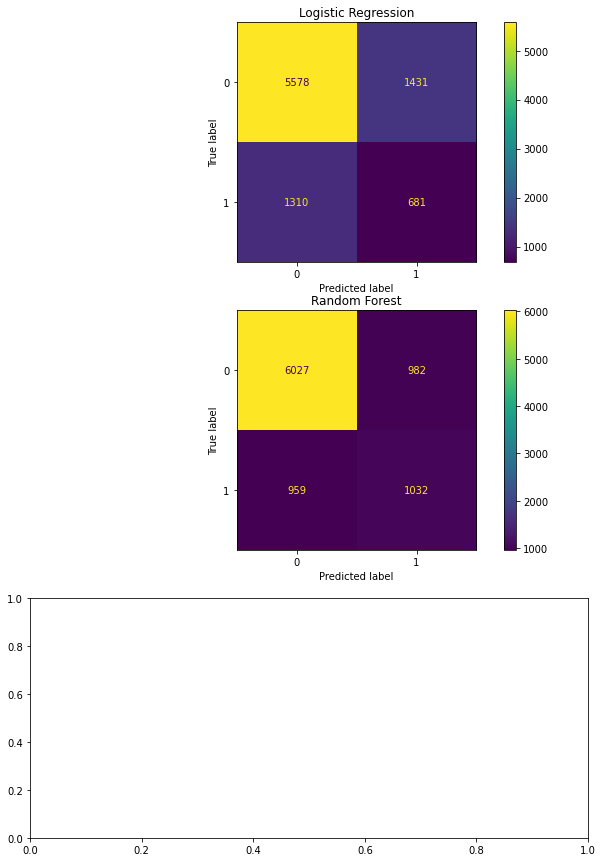

In [95]:
# Plot confusion matrix of 3 models

fig,ax=plt.subplots(3,1, figsize=(10,15))

plot_confusion_matrix(lr_best, X_test, y_test, ax = ax[0], values_format="d")
ax[0].set_title("Logistic Regression")

plot_confusion_matrix(rf_best, X_test, y_test, ax = ax[1], values_format="d")
ax[1].set_title("Random Forest")

plot_confusion_matrix(xgb_random, X_test, y_test, ax = ax[2], values_format="d")
ax[2].set_title("XGBoost")

ValueError: ignored

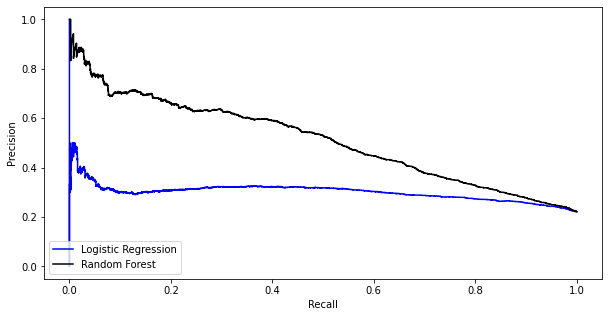

In [97]:
# Compare 3 models' Precision_recall curves

fig,ax=plt.subplots(figsize=(10,5))

plot_precision_recall_curve(lr_best, X_test, y_test, ax=ax,color="blue",label='Logistic Regression')
plot_precision_recall_curve(rf_best, X_test, y_test, ax=ax,color="black",label='Random Forest')
plot_precision_recall_curve(xgb_random, X_test, y_test, ax=ax,color="red",label='XGBoost')

plt.title('Precision_Recall of 3 models')
plt.grid()